<a href="https://colab.research.google.com/github/vincentbriat/Super-resolution-investigation/blob/main/Pruning_investigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Checks if the code is in a colab notebook

try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

Run on Colab notebook

In [2]:
if IN_COLAB:
  !pip install basicsr
  drive.mount('/content/drive/')
  !unzip /content/drive/MyDrive/Datasets/DIV2K_valid_HR.zip
  !unzip /content/drive/MyDrive/Datasets/DIV2K_valid_LR_clean.zip
  FOLDER_LR_TEST = 'DIV2K_valid_LR_clean'
  FOLDER_HR_TEST = 'DIV2K_valid_HR'

  STUDENT_MODEL_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/Models/student.pth'
  STUDENT_RECORDS_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/Models/student.csv'
  GENERATOR_MODEL_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/Models/generator.pth'
  GENERATOR_RECORDS_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/Models/generator.csv'

  TEACHER_MODEL_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/ESRGAN_models/RealESRGAN_x4plus.pth'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 KB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.9/305.9 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 72.6 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214839 sha256=8d21cced451f1b3ce8b6305539ef5e2e636ed5eb1764be51d6a8c079188104aa
  Stored in directory: /root/.cache/pip/wheels/42/d6/3d/6d8c4b8fabeb93dd442eb255f133e8928c75d903fe20e9472c
Successfully built basicsr
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Success

Run on my Windows desktop

In [ ]:
if not IN_COLAB:
  FOLDER_LR_TEST = 'D:\Downloads\Div2k\DIV2K_valid_LR_clean'
  FOLDER_HR_TEST = 'D:\Downloads\Div2k\DIV2K_valid_HR'
  
  STUDENT_MODEL_PATH='D:\oldDrive\ML\Indiv_Project\Second_Year\KD\Models\student.pth'
  STUDENT_RECORDS_PATH='D:\oldDrive\ML\Indiv_Project\Second_Year\KD\Models\student.csv'
  GENERATOR_MODEL_PATH='D:\oldDrive\ML\Indiv_Project\Second_Year\KD\Models\generator.pth'
  GENERATOR_RECORDS_PATH='D:\oldDrive\ML\Indiv_Project\Second_Year\KD\Models\generator.csv'

  TEACHER_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\KD\ESRGAN_models\RealESRGAN_x4plus.pth'

# Setup

In [17]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import cv2
import csv
import math
import numpy as np
import os
import queue
import threading
from basicsr.archs.rrdbnet_arch import RRDBNet
import torchvision
from os import listdir, environ, path
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# Making sure to use the gpu, if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.set_device(torch.device(0))

In [4]:
class DIV2KLoader(object):
  def __init__(self, low_res_folder, high_res_folder = None, preprocessing_input = None, preprocessing_output = None, include_targets = True):
    self.low_res_folder = low_res_folder
    self.high_res_folder = high_res_folder
    self.img_names = sorted(listdir(low_res_folder))
    self.include_targets = include_targets
    self.len = len(self.img_names)
    
    if include_targets or high_res_folder is not None:
      self.target_names = sorted(listdir(high_res_folder))

    if preprocessing_input is None:
      self.preprocessing_input = torchvision.transforms.ToTensor()
    else:
      self.preprocessing_input = preprocessing_input

    if preprocessing_output is None:
      self.preprocessing_output = torchvision.transforms.ToTensor()
    else:
      self.preprocessing_output = preprocessing_output
  
  def __getitem__(self, i):
    # Get the right image
    img = Image.open(Path(self.low_res_folder).joinpath(self.img_names[i]))
    if self.include_targets or self.high_res_folder is not None:
      target = Image.open(Path(self.high_res_folder).joinpath(self.target_names[i]))
      return self.preprocessing_input(img), self.preprocessing_output(target)
    else:
      return self.preprocessing_input(img)

  def __len__(self):
    return self.len
  
  def restrict_size(self, size):
    if size < len(self.img_names) and size > 0:
      self.len = size
    else:
      self.len = len(self.img_names)
      print(f"Size must be between 0 and {len(self.img_names)}")

In [5]:
# 0 is resize
# 1 is crop center
# 2 is crop random (requires finish implementation)

MODE = 1
IM_SIZE = 50

def resize_ratio(img, size=IM_SIZE):
  width, height = img.size
  if width > height:
    width, height = size, int(height * size / width)
  else:
    width, height = int(width * size / height), size
  return width, height

def preprocessing_output(img):
  im_w, im_h = img.size
  if MODE == 1:
    img = img.crop(((im_w - 400)/2, (im_h - 400)/2, (im_w + 400)/2, (im_h + 400)/2))
  elif MODE == 2:
    width, height = resize_ratio(img)
    origin_x, origin_y = 0, 0
    img = img.crop((origin_x, origin_y, origin_x + width*4, origin_y + height*4))
  return torchvision.transforms.ToTensor()(img).to(device)

def preprocessing_input(img):
  im_w, im_h = img.size
  if MODE == 1:
    img = img.crop(((im_w - 400)/2, (im_h - 400)/2, (im_w + 400)/2, (im_h + 400)/2)).resize((100, 100))
  elif MODE == 2:
    width, height = resize_ratio(img)
    origin_x, origin_y = 0, 0
    img = img.crop((origin_x, origin_y, origin_x + width*4, origin_y + height*4)).resize((width, height))
  return torchvision.transforms.ToTensor()(img).to(device)

data_test = DIV2KLoader(FOLDER_HR_TEST, FOLDER_HR_TEST, preprocessing_input=preprocessing_input, preprocessing_output=preprocessing_output)
data_test.restrict_size(10)
dataloader_test = torch.utils.data.DataLoader(data_test, batch_size=1, shuffle=False)

## RDDBNET

In [6]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, use_act: bool, **kwargs):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
    self.activation = nn.LeakyReLU(.2, inplace=True) if use_act else nn.Identity()

  def forward(self, x):
    return self.activation(self.conv(x))

class RDB(nn.Module):
  def __init__(self, in_channels, middle_channels = 32, residual_scale = .2):
    super().__init__()
    self.residual_scale = residual_scale
    self.block = nn.ModuleList([ConvBlock(in_channels + i * middle_channels,
                                  middle_channels if i<4 else in_channels,
                                  3,
                                  stride=1,
                                  padding=1,
                                  use_act=i<4) for i in range(5)])


  def forward(self, x):
    input = x
    for conv in self.block:
      out = conv(input)
      input = torch.cat([input, out], dim=1)
    return self.residual_scale * out + x

class RRDB(nn.Module):
  def __init__(self, in_channels, mid_channels = 32, residual_scale = .2):
    super().__init__()
    self.residual_scale = residual_scale
    self.model = nn.Sequential(*[RDB(in_channels, middle_channels = mid_channels, residual_scale = residual_scale) for _ in range(3)])
  
  def forward(self, x):
    return self.model(x) * self.residual_scale + x

class Head(nn.Module):
  def __init__(self, out_channels = 64) -> None:
    super().__init__()
    self.model = nn.Conv2d(3, out_channels, 3, stride=1, padding=1)

  def forward(self, x):
    return self.model(x)

class Tail(nn.Module):
  def __init__(self, in_channels = 64) -> None:
    super().__init__()
    self.model = nn.Sequential(nn.Conv2d(in_channels, 256, 3, stride=1, padding=1),
                               nn.Upsample(scale_factor=4, mode='nearest'),
                               nn.LeakyReLU(.2, inplace=True),
                               nn.Conv2d(256, 3, 3, stride=1, padding=1))
  
  def forward(self, x):
    return self.model(x)

## Real-ESRGAN

In [7]:
# https://github.com/xinntao/Real-ESRGAN/blob/5ca1078535923d485892caee7d7804380bfc87fd/realesrgan/utils.py

class RealESRGANer():
    """A helper class for upsampling images with RealESRGAN.
    Args:
        scale (int): Upsampling scale factor used in the networks. It is usually 2 or 4.
        model_path (str): The path to the pretrained model.
        model (nn.Module): The defined network. Default: None.
        tile (int): As too large images result in the out of GPU memory issue, so this tile option will first crop
            input images into tiles, and then process each of them. Finally, they will be merged into one image.
            0 denotes for do not use tile. Default: 0.
        tile_pad (int): The pad size for each tile, to remove border artifacts. Default: 10.
        pre_pad (int): Pad the input images to avoid border artifacts. Default: 10.
        half (bool): Whether to use half precision during inference. Default: False.
    """

    def __init__(self,
                 model_path,
                 tile=0,
                 tile_pad=10,
                 pre_pad=10,
                 half=False,
                 device=None,
                 gpu_id=None):
        self.tile_size = tile
        self.tile_pad = tile_pad
        self.pre_pad = pre_pad
        self.mod_scale = None
        self.half = half

        self.scale = 4

        # initialize model
        if gpu_id:
            self.device = torch.device(
                f'cuda:{gpu_id}' if torch.cuda.is_available() else 'cpu') if device is None else device
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') if device is None else device

        loadnet = torch.load(model_path, map_location=torch.device('cpu'))

        # prefer to use params_ema
        if 'params_ema' in loadnet:
            keyname = 'params_ema'
        else:
            keyname = 'params'
        
        model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
        model.load_state_dict(loadnet[keyname], strict=True)

        model.eval()
        self.model = model.to(self.device)
        if self.half:
            self.model = self.model.half()

    def dni(self, net_a, net_b, dni_weight, key='params', loc='cpu'):
        """Deep network interpolation.
        ``Paper: Deep Network Interpolation for Continuous Imagery Effect Transition``
        """
        net_a = torch.load(net_a, map_location=torch.device(loc))
        net_b = torch.load(net_b, map_location=torch.device(loc))
        for k, v_a in net_a[key].items():
            net_a[key][k] = dni_weight[0] * v_a + dni_weight[1] * net_b[key][k]
        return net_a

    def pre_process(self, img):
        """Pre-process, such as pre-pad and mod pad, so that the images can be divisible
        """
        img = torch.from_numpy(np.transpose(img, (2, 0, 1))).float()
        self.img = img.unsqueeze(0).to(self.device)
        if self.half:
            self.img = self.img.half()

        # pre_pad
        if self.pre_pad != 0:
            self.img = F.pad(self.img, (0, self.pre_pad, 0, self.pre_pad), 'reflect')
        # mod pad for divisible borders
        if self.scale == 2:
            self.mod_scale = 2
        elif self.scale == 1:
            self.mod_scale = 4
        if self.mod_scale is not None:
            self.mod_pad_h, self.mod_pad_w = 0, 0
            _, _, h, w = self.img.size()
            if (h % self.mod_scale != 0):
                self.mod_pad_h = (self.mod_scale - h % self.mod_scale)
            if (w % self.mod_scale != 0):
                self.mod_pad_w = (self.mod_scale - w % self.mod_scale)
            self.img = F.pad(self.img, (0, self.mod_pad_w, 0, self.mod_pad_h), 'reflect')

    def process(self):
        # model inference
        self.output = self.model(self.img)

    def tile_process(self):
        """It will first crop input images to tiles, and then process each tile.
        Finally, all the processed tiles are merged into one images.
        Modified from: https://github.com/ata4/esrgan-launcher
        """
        batch, channel, height, width = self.img.shape
        output_height = height * self.scale
        output_width = width * self.scale
        output_shape = (batch, channel, output_height, output_width)

        # start with black image
        self.output = self.img.new_zeros(output_shape)
        tiles_x = math.ceil(width / self.tile_size)
        tiles_y = math.ceil(height / self.tile_size)

        # loop over all tiles
        for y in range(tiles_y):
            for x in range(tiles_x):
                # extract tile from input image
                ofs_x = x * self.tile_size
                ofs_y = y * self.tile_size
                # input tile area on total image
                input_start_x = ofs_x
                input_end_x = min(ofs_x + self.tile_size, width)
                input_start_y = ofs_y
                input_end_y = min(ofs_y + self.tile_size, height)

                # input tile area on total image with padding
                input_start_x_pad = max(input_start_x - self.tile_pad, 0)
                input_end_x_pad = min(input_end_x + self.tile_pad, width)
                input_start_y_pad = max(input_start_y - self.tile_pad, 0)
                input_end_y_pad = min(input_end_y + self.tile_pad, height)

                # input tile dimensions
                input_tile_width = input_end_x - input_start_x
                input_tile_height = input_end_y - input_start_y
                tile_idx = y * tiles_x + x + 1
                input_tile = self.img[:, :, input_start_y_pad:input_end_y_pad, input_start_x_pad:input_end_x_pad]

                # upscale tile
                try:
                    with torch.no_grad():
                        output_tile = self.model(input_tile)
                except RuntimeError as error:
                    print('Error', error)
                print(f'\tTile {tile_idx}/{tiles_x * tiles_y}')

                # output tile area on total image
                output_start_x = input_start_x * self.scale
                output_end_x = input_end_x * self.scale
                output_start_y = input_start_y * self.scale
                output_end_y = input_end_y * self.scale

                # output tile area without padding
                output_start_x_tile = (input_start_x - input_start_x_pad) * self.scale
                output_end_x_tile = output_start_x_tile + input_tile_width * self.scale
                output_start_y_tile = (input_start_y - input_start_y_pad) * self.scale
                output_end_y_tile = output_start_y_tile + input_tile_height * self.scale

                # put tile into output image
                self.output[:, :, output_start_y:output_end_y,
                            output_start_x:output_end_x] = output_tile[:, :, output_start_y_tile:output_end_y_tile,
                                                                       output_start_x_tile:output_end_x_tile]

    def post_process(self):
        # remove extra pad
        if self.mod_scale is not None:
            _, _, h, w = self.output.size()
            self.output = self.output[:, :, 0:h - self.mod_pad_h * self.scale, 0:w - self.mod_pad_w * self.scale]
        # remove prepad
        if self.pre_pad != 0:
            _, _, h, w = self.output.size()
            self.output = self.output[:, :, 0:h - self.pre_pad * self.scale, 0:w - self.pre_pad * self.scale]
        return self.output

    @torch.no_grad()
    def enhance(self, img: np.array, alpha_upsampler='realesrgan'):
        h_input, w_input = img.shape[0:2]
        # img: numpy
        img = img.astype(np.float32)
        if np.max(img) > 256:  # 16-bit image
            max_range = 65535
            print('\tInput is a 16-bit image')
        else:
            max_range = 255
        img = img / max_range
        if len(img.shape) == 2:  # gray image
            img_mode = 'L'
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4:  # RGBA image with alpha channel
            img_mode = 'RGBA'
            alpha = img[:, :, 3]
            img = img[:, :, 0:3]
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if alpha_upsampler == 'realesrgan':
                alpha = cv2.cvtColor(alpha, cv2.COLOR_GRAY2RGB)
        else:
            img_mode = 'RGB'
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # ------------------- process image (without the alpha channel) ------------------- #
        self.pre_process(img)
        if self.tile_size > 0:
            self.tile_process()
        else:
            self.process()
        output_img = self.post_process()
        output_img = output_img.data.squeeze().float().cpu().clamp_(0, 1).numpy()
        output_img = np.transpose(output_img[[2, 1, 0], :, :], (1, 2, 0))
        if img_mode == 'L':
            output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2GRAY)

        # ------------------- process the alpha channel if necessary ------------------- #
        if img_mode == 'RGBA':
            print('Processing alpha channel:----------------')
            if alpha_upsampler == 'realesrgan':
                self.pre_process(alpha)
                if self.tile_size > 0:
                    self.tile_process()
                else:
                    self.process()
                output_alpha = self.post_process()
                output_alpha = output_alpha.data.squeeze().float().cpu().clamp_(0, 1).numpy()
                output_alpha = np.transpose(output_alpha[[2, 1, 0], :, :], (1, 2, 0))
                output_alpha = cv2.cvtColor(output_alpha, cv2.COLOR_BGR2GRAY)
            else:  # use the cv2 resize for alpha channel
                h, w = alpha.shape[0:2]
                output_alpha = cv2.resize(alpha, (w * self.scale, h * self.scale), interpolation=cv2.INTER_LINEAR)

            # merge the alpha channel
            output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2BGRA)
            output_img[:, :, 3] = output_alpha

        # ------------------------------ return ------------------------------ #
        if max_range == 65535:  # 16-bit image
            output = (output_img * 65535.0).round().astype(np.uint16)
        else:
            output = (output_img * 255.0).round().astype(np.uint8)

        return output


class PrefetchReader(threading.Thread):
    """Prefetch images.
    Args:
        img_list (list[str]): A image list of image paths to be read.
        num_prefetch_queue (int): Number of prefetch queue.
    """

    def __init__(self, img_list, num_prefetch_queue):
        super().__init__()
        self.que = queue.Queue(num_prefetch_queue)
        self.img_list = img_list

    def run(self):
        for img_path in self.img_list:
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            self.que.put(img)

        self.que.put(None)

    def __next__(self):
        next_item = self.que.get()
        if next_item is None:
            raise StopIteration
        return next_item

    def __iter__(self):
        return self


class IOConsumer(threading.Thread):

    def __init__(self, opt, que, qid):
        super().__init__()
        self._queue = que
        self.qid = qid
        self.opt = opt

    def run(self):
        while True:
            msg = self._queue.get()
            if isinstance(msg, str) and msg == 'quit':
                break

            output = msg['output']
            save_path = msg['save_path']
            cv2.imwrite(save_path, output)
        print(f'IO worker {self.qid} is done.')

# Pruning

In [8]:
import torch.nn.utils.prune as prune

In [10]:
teacher = RealESRGANer(TEACHER_MODEL_PATH, tile=600)
son = RealESRGANer(TEACHER_MODEL_PATH, tile=600)

## Pruning setup

In [9]:
def display_sparsity(model):
  count_zeros, count_all = 0, 0

  for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
      zeros, all = torch.sum(module.weight == 0), module.weight.nelement()
      print(f'Sparsity in {name}: {100. * float(zeros) / float(all):.2f}%')
      count_zeros += zeros
      count_all += all
  print(f'Sparsity in the whole model {(count_zeros/count_all).item()*100:.2f}%')

## Global unstructured pruning

In [93]:
parameters = []
for name, module in son.model.named_modules():
  if isinstance(module, torch.nn.Conv2d):
    parameters.append((module, 'weight'))

prune.global_unstructured(parameters, pruning_method=prune.L1Unstructured, amount=.2)

In [103]:
display_sparsity(son.model)

Sparsity in conv_first: 16.44%
Sparsity in body.0.rdb1.conv1: 20.65%
Sparsity in body.0.rdb1.conv2: 18.87%
Sparsity in body.0.rdb1.conv3: 20.21%
Sparsity in body.0.rdb1.conv4: 24.59%
Sparsity in body.0.rdb1.conv5: 35.32%
Sparsity in body.0.rdb2.conv1: 35.22%
Sparsity in body.0.rdb2.conv2: 27.63%
Sparsity in body.0.rdb2.conv3: 25.95%
Sparsity in body.0.rdb2.conv4: 23.03%
Sparsity in body.0.rdb2.conv5: 27.33%
Sparsity in body.0.rdb3.conv1: 32.36%
Sparsity in body.0.rdb3.conv2: 25.49%
Sparsity in body.0.rdb3.conv3: 21.95%
Sparsity in body.0.rdb3.conv4: 17.87%
Sparsity in body.0.rdb3.conv5: 14.13%
Sparsity in body.1.rdb1.conv1: 22.91%
Sparsity in body.1.rdb1.conv2: 20.53%
Sparsity in body.1.rdb1.conv3: 19.24%
Sparsity in body.1.rdb1.conv4: 18.58%
Sparsity in body.1.rdb1.conv5: 21.47%
Sparsity in body.1.rdb2.conv1: 25.54%
Sparsity in body.1.rdb2.conv2: 22.12%
Sparsity in body.1.rdb2.conv3: 19.94%
Sparsity in body.1.rdb2.conv4: 17.61%
Sparsity in body.1.rdb2.conv5: 19.63%
Sparsity in body.1.

Performance of the teacher model

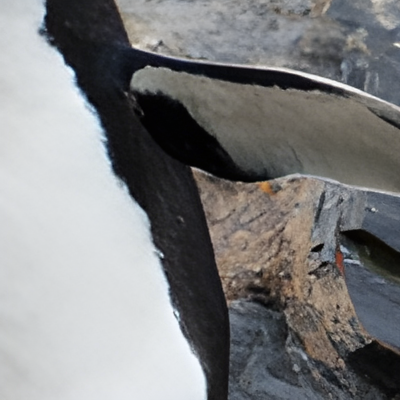

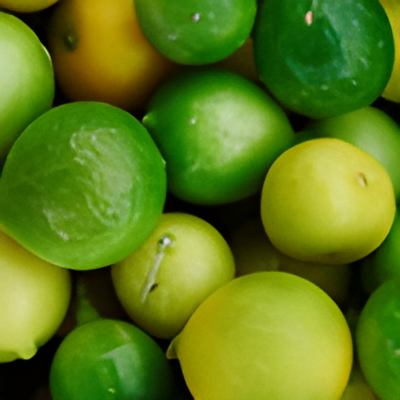

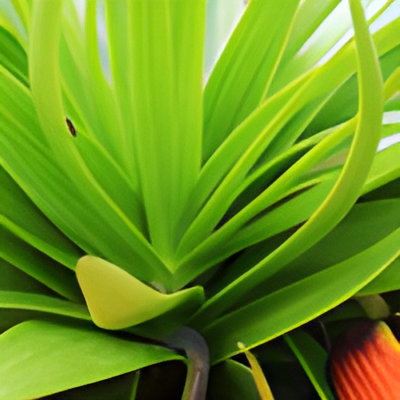

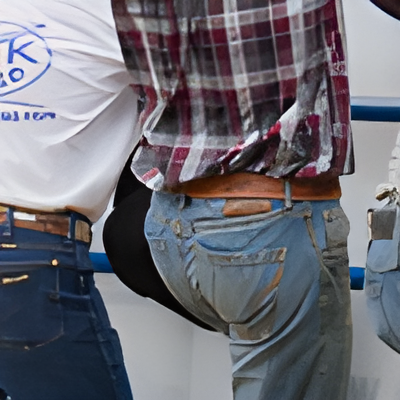

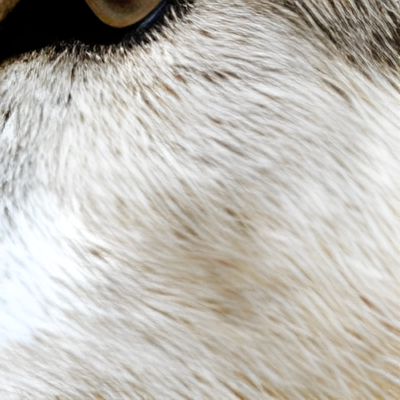

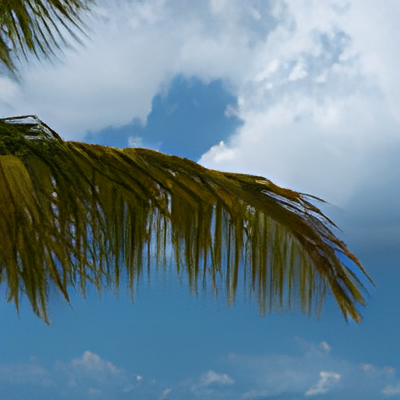

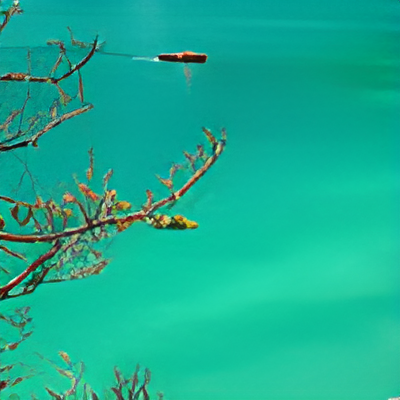

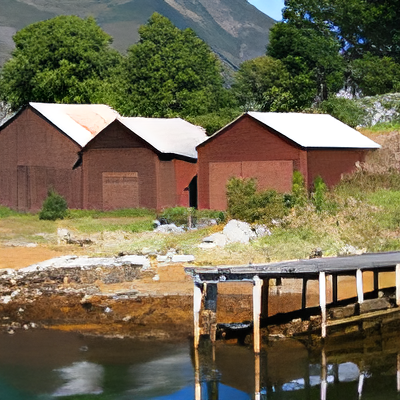

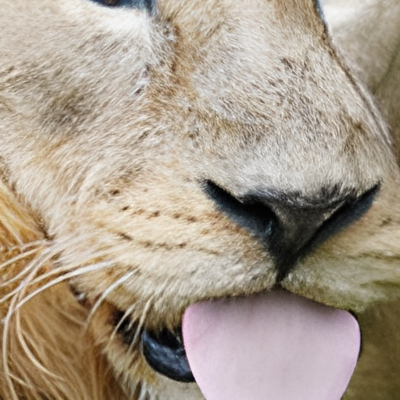

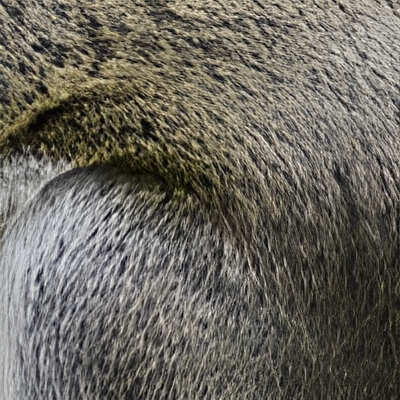

In [87]:
for i in range(10):
  test = torch.zeros_like(data_test[i][0].unsqueeze(0))
  test[0] = data_test[i][0]
  display(torchvision.transforms.ToPILImage()(torch.clamp(teacher.model(test.to(device=device))[0], min=0, max=1)))

Pruned child model

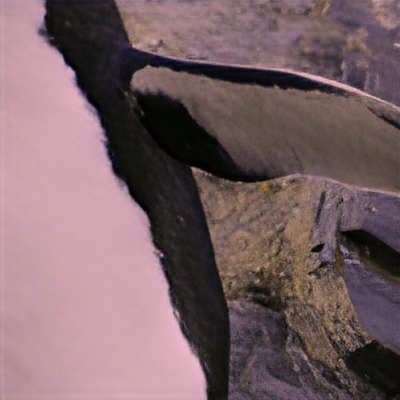

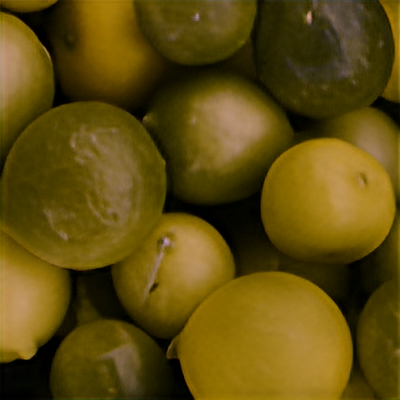

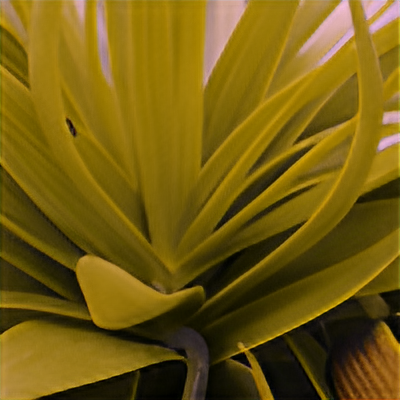

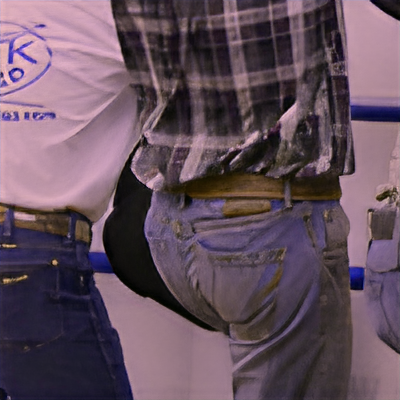

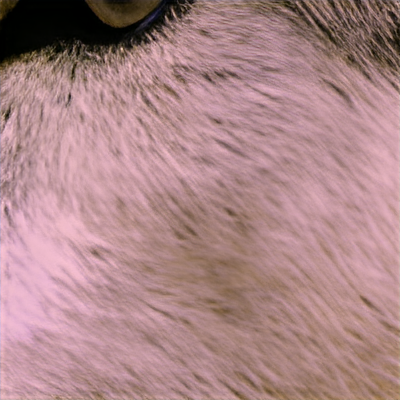

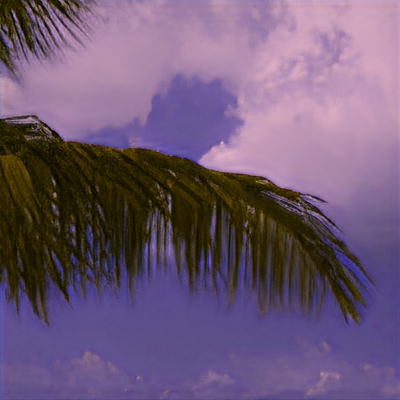

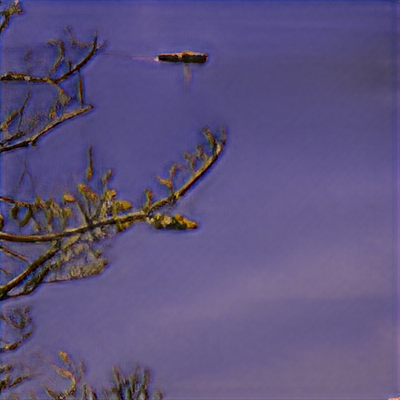

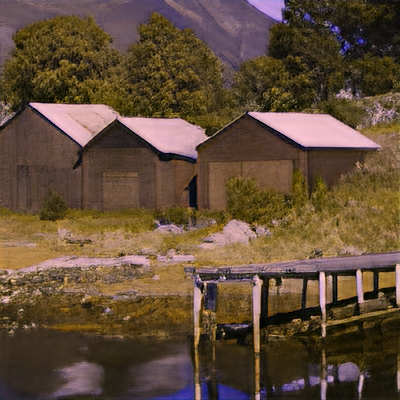

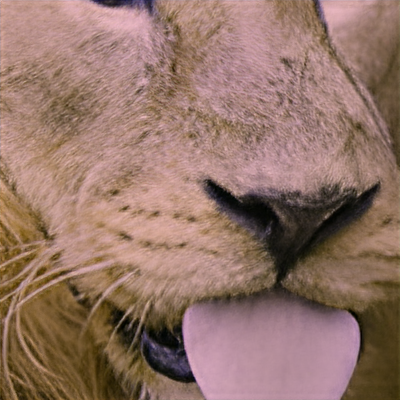

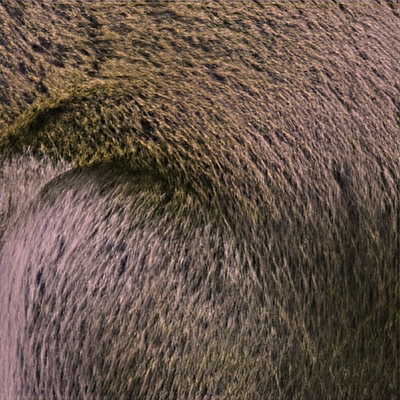

In [95]:
for i in range(10):
  test = torch.zeros_like(data_test[i][0].unsqueeze(0))
  test[0] = data_test[i][0]
  display(torchvision.transforms.ToPILImage()(torch.clamp(son.model(test.to(device=device))[0], min=0, max=1)))

We see a considerable loss in performance with 20% pruning on the whole network using the global_unstructured_prune method.

We can optimize this process by setting custom pruning ratios for each layer.

## Custom pruning ratios

In [45]:
son = RealESRGANer(TEACHER_MODEL_PATH, tile=600)

In [46]:
for name, module in son.model.named_modules():
  if isinstance(module, nn.Conv2d):
    1728, 18432, 27648, 36864, 46080, 110592
    if module.weight.numel() == 110592:
      amount = .8
    elif module.weight.numel() == 46080:
      amount = .99
    elif module.weight.numel() == 36864:
      amount = .3
    elif module.weight.numel() == 27648:
      amount = .99
    elif module.weight.numel() == 18432:
      amount = .99
    elif module.weight.numel() == 1728:
      amount = .0
    else:
      amount = 0.
    prune.l1_unstructured(module, name='weight', amount=amount)

In [47]:
display_sparsity(son.model)

Sparsity in conv_first: 0.00%
Sparsity in body.0.rdb1.conv1: 99.00%
Sparsity in body.0.rdb1.conv2: 99.00%
Sparsity in body.0.rdb1.conv3: 30.00%
Sparsity in body.0.rdb1.conv4: 99.00%
Sparsity in body.0.rdb1.conv5: 80.00%
Sparsity in body.0.rdb2.conv1: 99.00%
Sparsity in body.0.rdb2.conv2: 99.00%
Sparsity in body.0.rdb2.conv3: 30.00%
Sparsity in body.0.rdb2.conv4: 99.00%
Sparsity in body.0.rdb2.conv5: 80.00%
Sparsity in body.0.rdb3.conv1: 99.00%
Sparsity in body.0.rdb3.conv2: 99.00%
Sparsity in body.0.rdb3.conv3: 30.00%
Sparsity in body.0.rdb3.conv4: 99.00%
Sparsity in body.0.rdb3.conv5: 80.00%
Sparsity in body.1.rdb1.conv1: 99.00%
Sparsity in body.1.rdb1.conv2: 99.00%
Sparsity in body.1.rdb1.conv3: 30.00%
Sparsity in body.1.rdb1.conv4: 99.00%
Sparsity in body.1.rdb1.conv5: 80.00%
Sparsity in body.1.rdb2.conv1: 99.00%
Sparsity in body.1.rdb2.conv2: 99.00%
Sparsity in body.1.rdb2.conv3: 30.00%
Sparsity in body.1.rdb2.conv4: 99.00%
Sparsity in body.1.rdb2.conv5: 80.00%
Sparsity in body.1.r

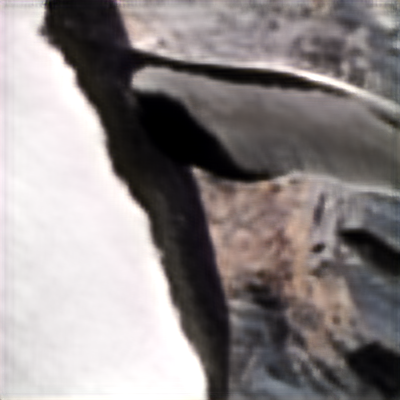

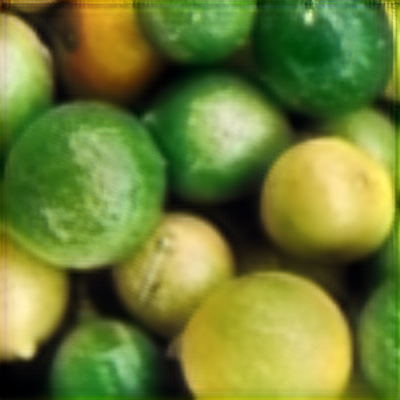

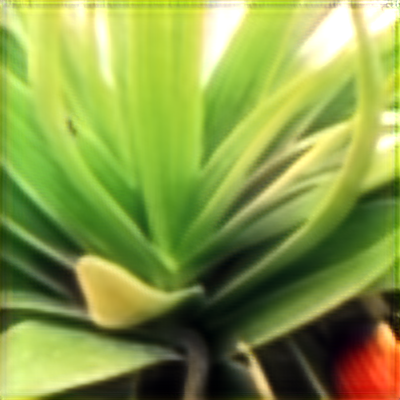

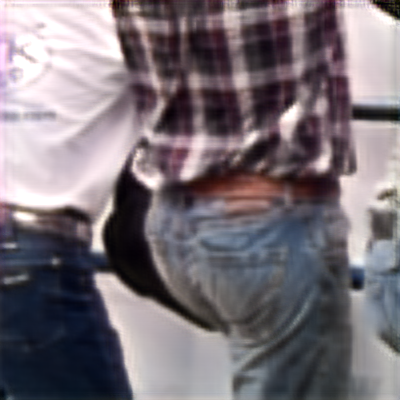

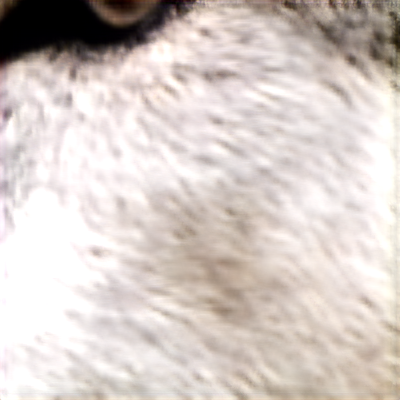

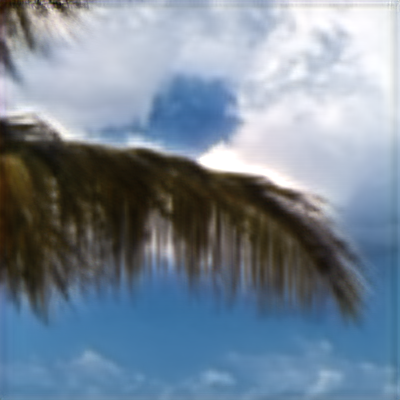

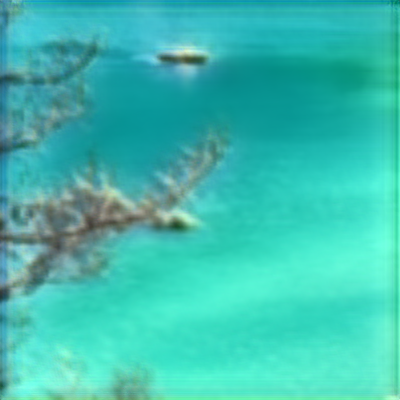

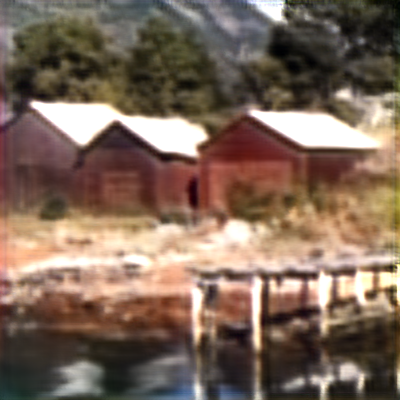

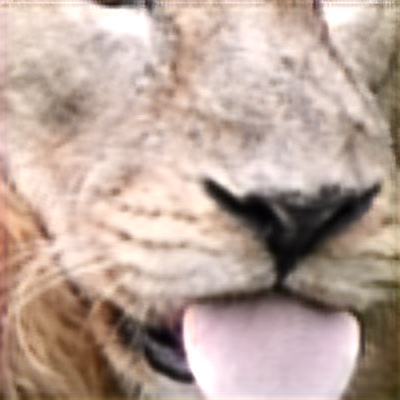

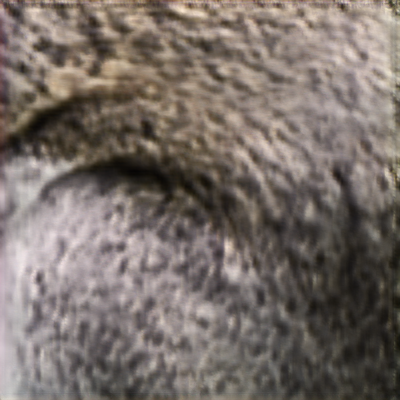

In [48]:
for i in range(10):
  test = torch.zeros_like(data_test[i][0].unsqueeze(0))
  test[0] = data_test[i][0]
  display(torchvision.transforms.ToPILImage()(torch.clamp(son.model(test.to(device=device))[0], min=0, max=1)))

In [52]:
torch.save({'state_dict': son.model.state_dict()}, 'drive/MyDrive/ML/Indiv_Project/Second_Year/Pruning/80_percent/son.pth')

In [51]:
for _, module in son.model.named_modules():
  if isinstance(module, nn.Conv2d):
    print(list(module.buffers()))

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

# Investigation of the impact of pruning ratio various weights

In [28]:
LAYER_SIZES = [1728, 18432, 27648, 36864, 46080, 110592]

class Pruning_Ratio_investigation:
  def __init__(self, dataloader):
    self.reset_model()
    self.length = self.get_length()
    self.dataloader = dataloader

  def get_length(self):
    length = 0
    for _, module in self.model.named_modules():
      if isinstance(module, nn.Conv2d):
        length += 1
    return length

  def reset_model(self):
    self.model = RealESRGANer(TEACHER_MODEL_PATH).model
    self.model.to(device=device)
  
  def test_all_layers(self, start = 0, group_layers: bool = False):
    results = []
    filename = f'drive/MyDrive/ML/Indiv_Project/Second_Year/Pruning/pruning_ratio_investigation_group_999.csv'

    # Layers have discrete sizes with their number of parameters being 
    # 1728, 18432, 27648, 36864, 46080, 110592
    # We will investigate various amounts for each value

    if start == 0:
      self.record(filename=filename, data = ['Layers size', '0.9991', '0.9992', '0.9993', '0.9994', '0.9995', '0.9996', '0.9997', '0.9998', '0.9999'], append=False)

    if group_layers:
      results = []
      for layer_size in range(start, len(LAYER_SIZES)):
        print(f'Testing layer size {LAYER_SIZES[layer_size]}/{LAYER_SIZES[-1]}')
        layer_results = [LAYER_SIZES[layer_size]]
        for amount in range(1,10):
          print(f'{.999+amount/10000}')
          layer_results.append(self.test_group_layers(LAYER_SIZES[layer_size], .999+amount/10000))
        self.record(filename=filename, data=layer_results)
        results.append(layer_results)

    else:
      for layer in range(start, self.length):
        print(f'Testing layer {layer}/{self.length}')
        layer_results = [layer]
        for amount in range(1,10):
          print(f'{amount/10}')
          layer_results.append(self.test_layer(layer=layer, amount=amount/10))
        self.record(filename=filename, data=layer_results)
        results.append(layer_results)
    return results

  def test_layer(self, layer: int, amount: float):
    self.reset_model()
    index = 0
    for name, module in self.model.named_modules():
      if isinstance(module, nn.Conv2d):
        if index == layer:
          prune.l1_unstructured(module, name='weight', amount=amount)
          break
        index += 1
    return self.test()
  
  def test_group_layers(self, layer_size: int, amount: float):
    self.reset_model()
    for name, module in self.model.named_modules():
      if isinstance(module, nn.Conv2d) and module.weight.numel() == layer_size:
        prune.l1_unstructured(module, name='weight', amount=amount)
    return self.test()

  def test(self, loss_fn: nn.modules.loss._Loss = nn.MSELoss()):
    self.model.eval()
    loss = 0
    for batch, (X,y) in enumerate(self.dataloader):
      # if batch % 50 == 0:
      #   print(batch)
      loss += loss_fn(self.model(X.to(device)),y.to(device)).item()
    
    return loss/len(self.dataloader)
  
  def record(self, filename: str, data: list, append: bool = True):
    with open(filename, 'a' if append else 'w') as f:
      csv.writer(f).writerow(data)
    print(f'Successfully recorded in {filename}')

  def read_results(self):
    filenames = ['drive/MyDrive/ML/Indiv_Project/Second_Year/Pruning/pruning_ratio_investigation_group.csv',
                 'drive/MyDrive/ML/Indiv_Project/Second_Year/Pruning/pruning_ratio_investigation_group_9.csv',
                 'drive/MyDrive/ML/Indiv_Project/Second_Year/Pruning/pruning_ratio_investigation_group_99.csv',
                 'drive/MyDrive/ML/Indiv_Project/Second_Year/Pruning/pruning_ratio_investigation_group_999.csv']

    results = []
    for filename in filenames:
      tmp = []
      with open(filename, 'r') as f:
        for row in csv.reader(f):
          tmp.append(row)
      results.append(tmp)
    return results

In [11]:
pri = Pruning_Ratio_investigation(dataloader_test)
#test_results = pri.test_all_layers(group_layers=True)

Let's analyze the results of the previous experiments

In [41]:
results_data = pri.read_results()

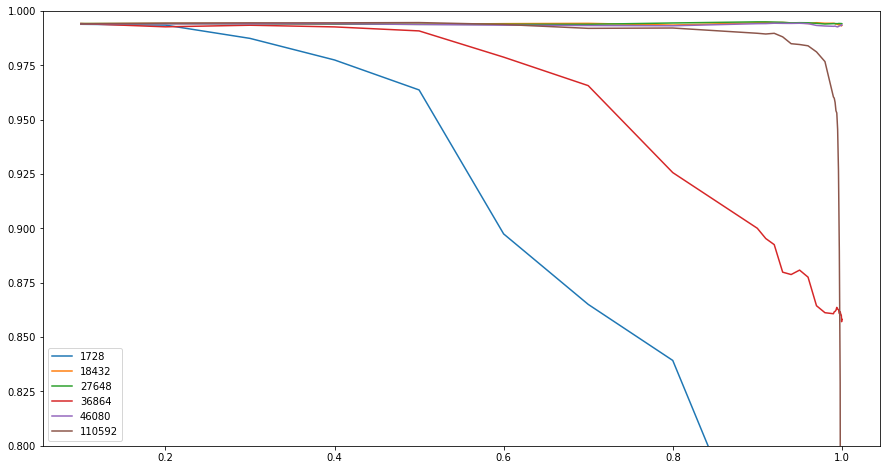

In [43]:
plt.figure(figsize=(15,8))
for i in range(1, len(results_data[0])):
  xs, ys = [], []
  for _file in range(len(results_data)):
    xs += list(map(lambda x: float(x), results_data[_file][0][1:]))
    ys += list(map(lambda x: 1-float(x), results_data[_file][i][1:]))
  plt.plot(xs, ys, label=f'{LAYER_SIZES[i-1]}')
  plt.ylim(.8,1)
  plt.legend()

Most of the MSE loss does not reach 0.2. We can try and remove most weights while keeping most of the performance. We will experiment reducing the performance and re-training the model iteratively to reach the old performance.